# Intercative development
This notebook is for interactive test of searched methods of segmentation

In [2]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import math

The block is intended for setting up image file pathes.

In [3]:
type_A = 'D:/pythonproject/ostracod/test/HK14THL1C_104_105_50X.tif'
type_B = 'D:/pythonproject/ostracod/test/HK14THL1C_136_137_50X.tif'

1. Read and down-scale 32x times

In [4]:
def read_and_down(file_path, down_factor=32):
    src = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    width = int(src.shape[1] // down_factor)
    height = int(src.shape[0] // down_factor)
    dim = (width, height)
    src = cv2.resize(src, dim, interpolation=cv2.INTER_AREA)
    return src

In [5]:
plate_a = read_and_down(type_A)
plate_b = read_and_down(type_B,16)

In [6]:
org_a = cv2.imread(type_A)

In [7]:
org_b = cv2.imread(type_B)

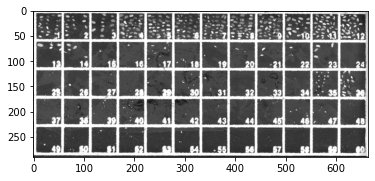

In [8]:
plt.imshow(plate_a,'gray')
plt.show()

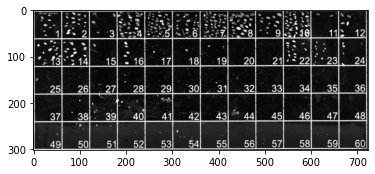

In [9]:
plt.imshow(plate_b,'gray')
plt.show()

Plot image thresholds

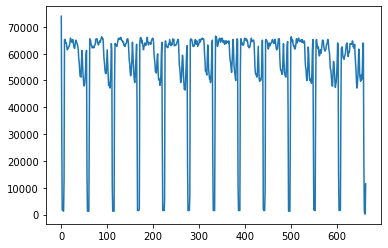

In [10]:
img_thr = cv2.threshold(plate_a, 160, 255, cv2.THRESH_BINARY_INV)[1]
w_proj = img_thr.sum(axis=0)
plt.plot(w_proj)
plt.show()

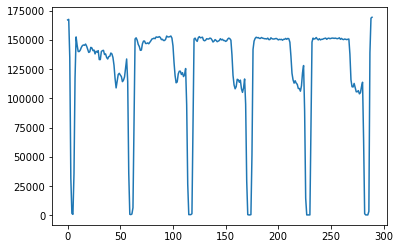

In [11]:
h_proj = img_thr.sum(axis=1)
plt.plot(h_proj)
plt.show()

In [12]:
h_proj.max()*0.5

84660.0

In [13]:
def axis_candidate(projection):
    # Assumed sepration: 12*5
    threshold = projection.max()*0.4
    axis_candidates = []
    for p in range(0,projection.size):
        if projection[p] <= threshold:
            axis_candidates.append(p)
    return axis_candidates

def clean_candidates(candidates, projections, if_x = 1):
    axis_breaks = []
    if if_x == 0:
        axis_factor = 12
    else:
        axis_factor = 5
    break_length = projections.size/axis_factor
    for c in range(1,len(candidates)):
        if candidates[c] - candidates[c-1] > break_length/2:
            
            axis_breaks.append(candidates[c-1])
            axis_breaks.append(candidates[c])
            break_length = break_length*11/axis_factor + (candidates[c] - candidates[c-1])/axis_factor  
    return axis_breaks
            
def grid_crop(x_cand, y_cand, trgt, file_string, scale):
    m = len(x_cand)
    n = len(y_cand)
    sub_images = []
    for y in range(0,n-1,2):
        for x in range(0,m-1,2):
            sub_images.append(trgt[y_cand[y]*scale:y_cand[y+1]*scale,x_cand[x]*scale:x_cand[x+1]*scale])
    p = 1
    for img in sub_images:
        fs = file_string +str(p)+'.tif'
        cv2.imwrite(fs,img)
        p +=1

In [14]:
cnd_x = clean_candidates(axis_candidate(w_proj), w_proj)
cnd_y = clean_candidates(axis_candidate(h_proj), h_proj,0)
file_string = 'E:/HKU_Study/PhD/Lab_work/Keyence_Images/HK14THL1C_64_65_50X_grid_'
grid_crop(cnd_x, cnd_y, org_a, file_string, 32)

In [15]:
thr_b = cv2.threshold(plate_b, 160, 255, cv2.THRESH_BINARY_INV)[1]
h_proj_b = thr_b.sum(axis=1)
w_proj_b = thr_b.sum(axis=0)
cnd_x_b = clean_candidates(axis_candidate(w_proj_b), w_proj_b)
cnd_y_b = clean_candidates(axis_candidate(h_proj_b), h_proj_b, 0)

In [175]:
file_string_b = 'E:/HKU_Study/PhD/Lab_work/Keyence_Images/HK14THL1C_150_151_100X_grid_'
grid_crop(cnd_x_b, cnd_y_b, org_b, file_string_b, 8)

In [182]:
array = ["1","2","4"]
print(str.join(array[:-1],''))
print(array[1])

TypeError: descriptor 'join' requires a 'str' object but received a 'list'

Test 1: edge detection

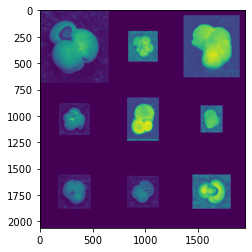

In [3]:
img_test1 = cv2.imread(imfile,0)
plt.imshow(img_test1)
plt.show()

As observed below, the result is not ideal.
the clear boundary between the image and background is bad for the segmentation. We should remove the boundary first. Some images are commpanying with clear boundaries while others are not.

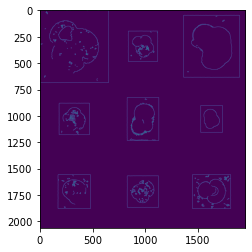

In [4]:
blurred = cv2.blur(img_test1, (3,3))
canny = cv2.Canny(blurred, 10, 90)
plt.imshow(canny)
plt.show()

Test 2: segmentation by treashold

In [5]:
ret,thresh1 = cv2.threshold(blurred,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(blurred,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(blurred,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(blurred,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(blurred,127,255,cv2.THRESH_TOZERO_INV)

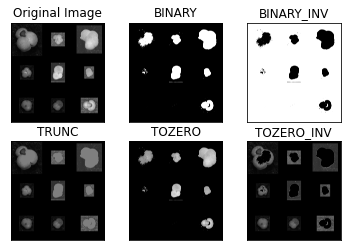

In [6]:
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [blurred, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [7]:
def easyplot(imgs, names, row, col):
    titles = names
    images = imgs
    for i in range(len(images)):
        plt.subplot(row,col,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

The result inclined that we should apply different method to the result from different collections. <br>
Thus sample two images from different collections for convient

1. Segment on the orginal data, make masks for all images.
2. Apply the mask to transparent out back ground pixels.
3. Paste image with transparent backgound into artifical backgrounds to make compositions.

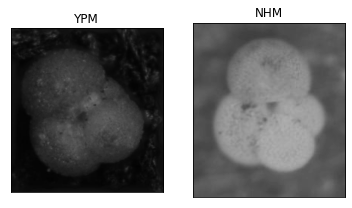

In [44]:
YPM = cv2.imread(solo_img_YPM, cv2.COLOR_BGR2BGRA)
NHM = cv2.imread(solo_img_NHM, cv2.COLOR_BGR2BGRA)

images = [YPM,NHM]
names = ['YPM','NHM']
easyplot(images,names,1,2)
# for i in range(2):
#     plt.subplot(1,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
#     plt.title(titles[i])
#     plt.xticks([]),plt.yticks([])
# plt.show()

As observed above, the YPM collection image is suitable for treahold while NHM shoud be better using segmentation

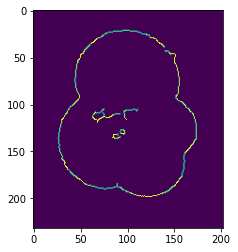

In [33]:
NHM_blurred = cv2.blur(NHM, (3,3))
NHM_canny = cv2.Canny(NHM_blurred, 10, 90)
plt.imshow(NHM_canny)
plt.show()

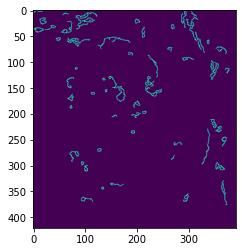

In [40]:
YPM_blurred = cv2.blur(YPM, (3,3))
YPM_canny = cv2.Canny(YPM_blurred, 10, 70)
plt.imshow(YPM_canny)
plt.show()

In [10]:
def multiple_thresold(img, lower_bound=127, upper_bound=255):
    blurred = cv2.blur(img, (3,3))
    ret,thresh1 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(blurred,lower_bound,upper_bound,cv2.THRESH_TOZERO_INV)
    imgs = [blurred, thresh1, thresh2, thresh3, thresh4, thresh5]
    titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
    return imgs,titles

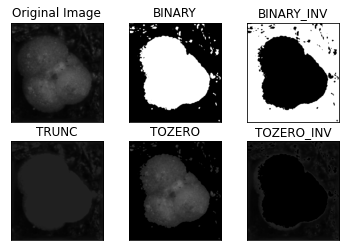

In [41]:
imgs_YPM, names_YPM = multiple_thresold(YPM,33)
easyplot(imgs_YPM, names_YPM,2,3)

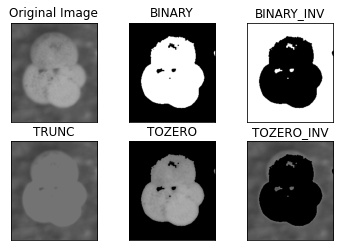

In [19]:
imgs_NHM, names_NHM = multiple_thresold(NHM,115)
easyplot(imgs_NHM, names_NHM,2,3)

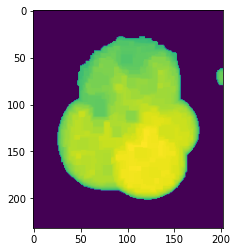

In [53]:
ret, thresh = cv2.threshold(NHM, 115, 255, cv2.THRESH_TOZERO)
rect=cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilation = cv2.dilate(thresh,rect,iterations = 6)
erosion = cv2.erode(dilation, rect, iterations=4)
plt.imshow(erosion)
plt.show()

Test the mask function

In [49]:
def transparent_out(img, mask):
    res = img.copy()
    res = cv2.cvtColor(res, cv2.COLOR_BGR2BGRA)
    res[:, :, 3] = mask
    return res

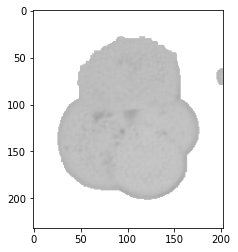

In [54]:
masked = transparent_out(NHM, erosion)#cv2.bitwise_and(NHM, NHM, mask=erosion)
plt.imshow(masked)
plt.show()

In [56]:
cv2.imwrite('masked.png', masked)

True

Adaptive threshold

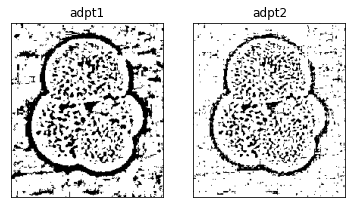

In [15]:
th2 = cv2.adaptiveThreshold(NHM,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(NHM,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

titles = ['adpt1','adpt2']
images = [th2, th3]

easyplot(images, titles, 1,2)

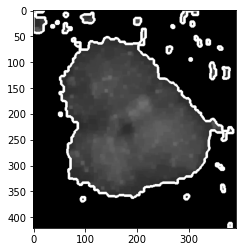

In [32]:
contours, hierarchy = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(erosion, contours, -1, (255,255,255),3)
plt.imshow(erosion,'gray')
plt.show()

rgb filter
stomata 